# Image alignment

In this notebook, I will learn aligning a scanned copy with the original / correct aligned image

## Importing the library

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

%matplotlib inline

## Download the asset

In [4]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

URL = r"https://www.dropbox.com/s/zuwnn6rqe0f4zgh/opencv_bootcamp_assets_NB8.zip?dl=1"
asset_zip_path = os.path.join(os.getcwd()+"/images", f"opencv_bootcamp_assets_NB8.zip")
# Download if assest ZIP does not exists. 
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path) 

## Reading the scanned and template image

In [5]:
refFilename = "images/form.jpg"
imFilename = "images/scanned-form.jpg"
image1_bgr = cv2.imread(refFilename,cv2.IMREAD_COLOR)
image1_rgb = cv2.cvtColor(image1_bgr,cv2.COLOR_BGR2RGB)

image2_bgr = cv2.imread(imFilename,cv2.IMREAD_COLOR)
image2_rgb = cv2.cvtColor(image2_bgr,cv2.COLOR_BGR2RGB)

Text(0.5, 0.98, 'Images')

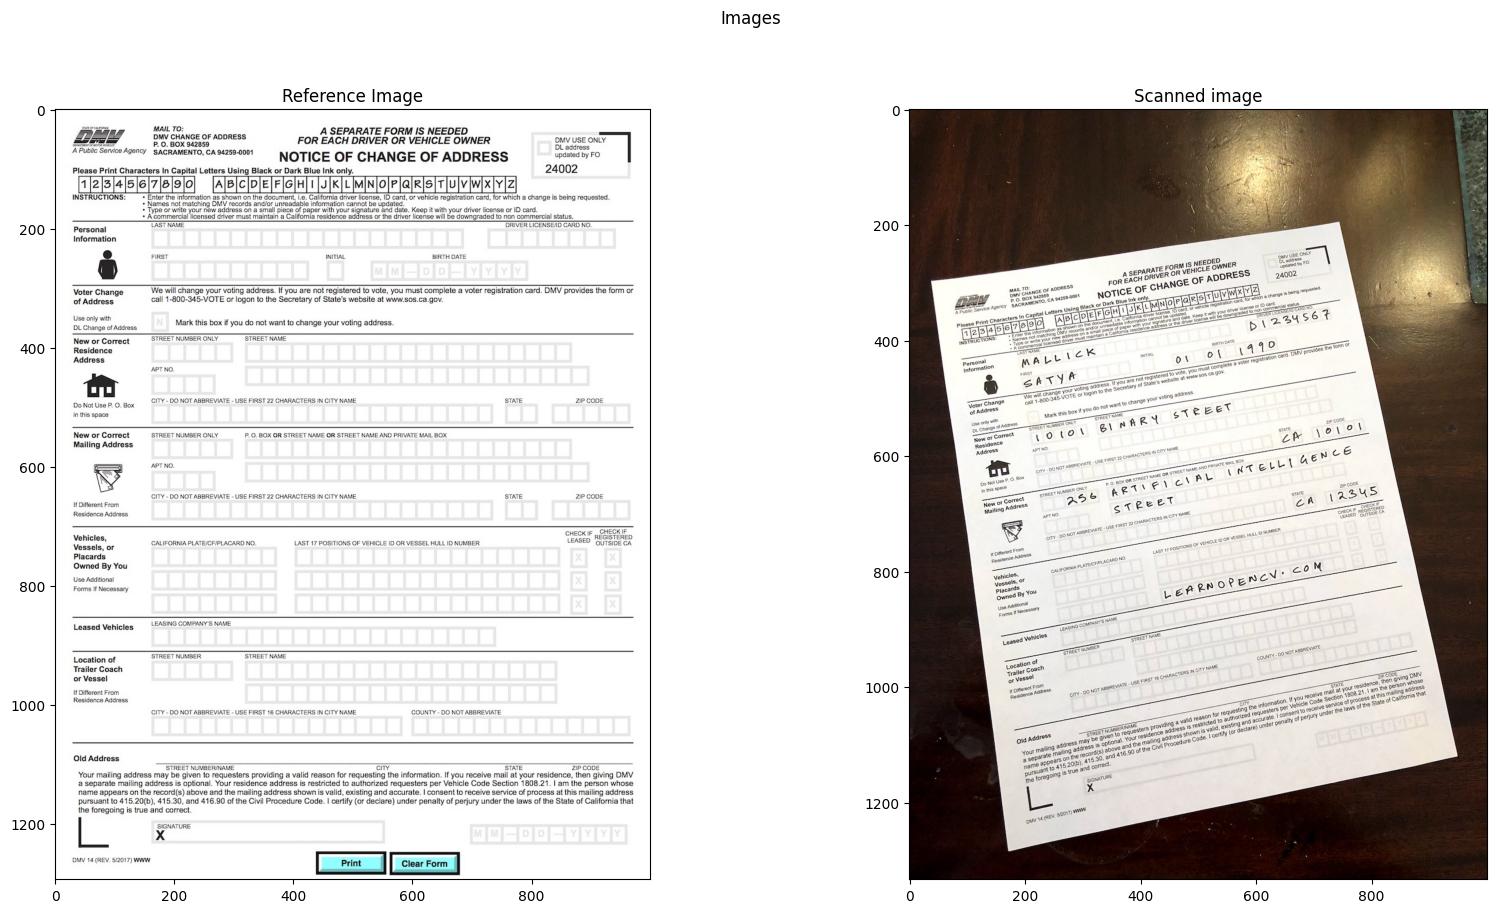

In [6]:
plt.figure(figsize=(20,10))
plt.subplot(121);plt.imshow(image1_rgb);plt.title("Reference Image")
plt.subplot(122);plt.imshow(image2_rgb);plt.title("Scanned image")
plt.suptitle("Images")

## Adding key points to the images

To add the keypoints in the images, we use [ORB](https://docs.opencv.org/3.4/d1/d89/tutorial_py_orb.html) features. ORB full form is Oriented FAST and Rotated BRIEF. By reading the documentation, I think ORB is used to detect the edge points of an image.

Text(0.5, 0.98, 'Keypoint images')

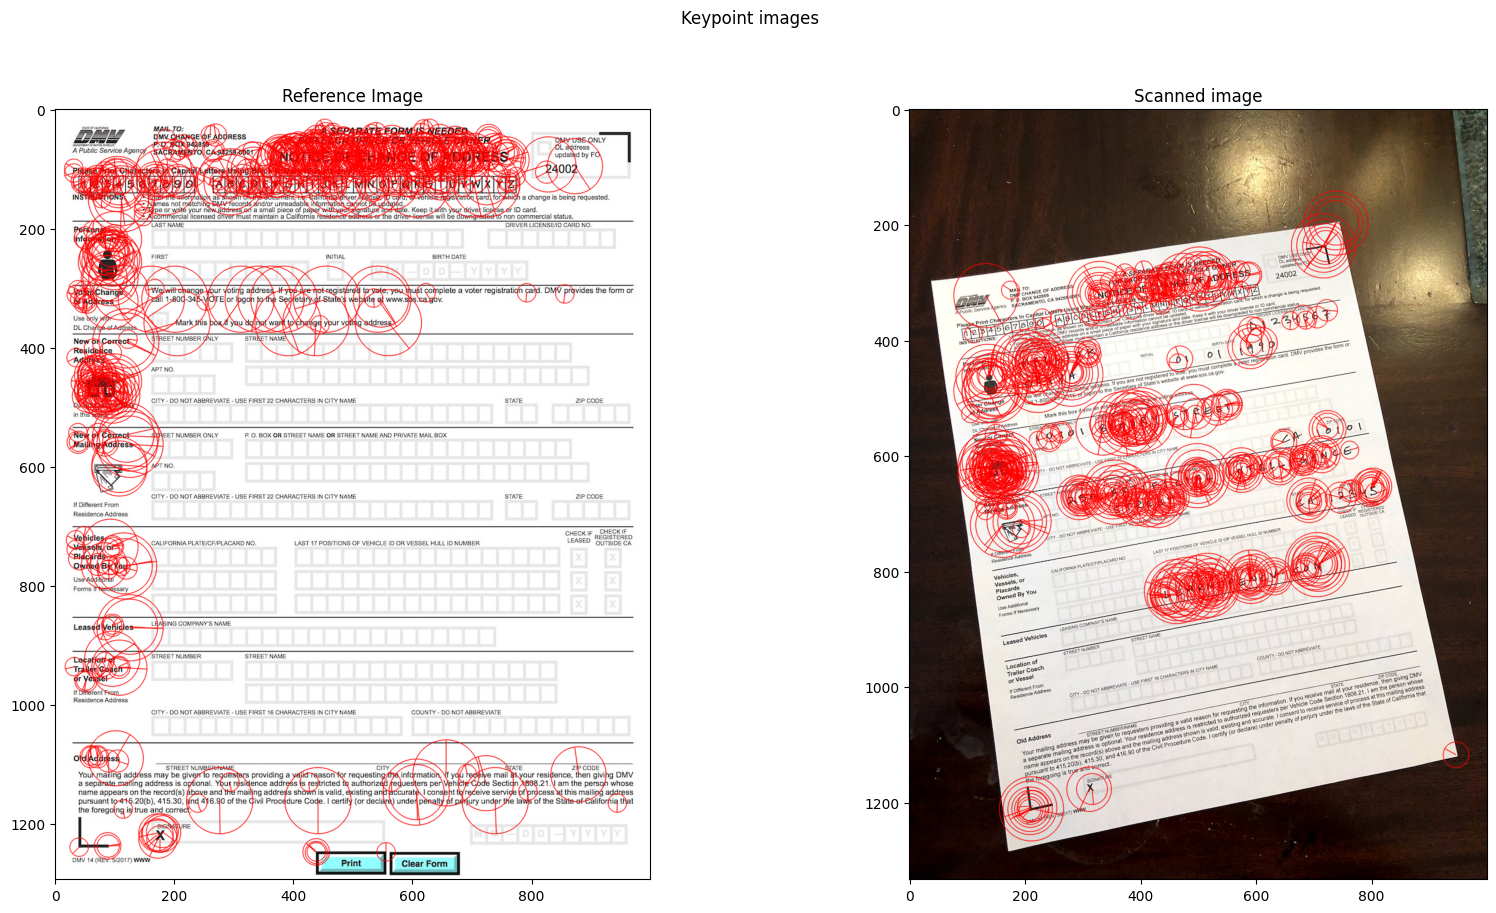

In [9]:
# to detect the keypoints first converting the color image to grayscale
image1_gray = cv2.cvtColor(image1_rgb,cv2.COLOR_RGB2GRAY)
image2_gray = cv2.cvtColor(image2_rgb,cv2.COLOR_RGB2GRAY)

# ORB detector
MAX_NUM_FEATURES = 500
orb = cv2.ORB_create(MAX_NUM_FEATURES)
keypoints1, descriptors1 = orb.detectAndCompute(image1_gray,None)
keypoints2, descriptors2 = orb.detectAndCompute(image2_gray,None)

# to display
image1_display = cv2.drawKeypoints(image1_rgb,keypoints1,outImage=np.array([]),color = (255,0,0),flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
image2_display = cv2.drawKeypoints(image2_rgb,keypoints2,outImage=np.array([]),color = (255,0,0),flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(20,10))
plt.subplot(121);plt.imshow(image1_display);plt.title("Reference Image")
plt.subplot(122);plt.imshow(image2_display);plt.title("Scanned image")
plt.suptitle("Keypoint images")

## Matching the descriptors

Text(0.5, 1.0, 'Original Form')

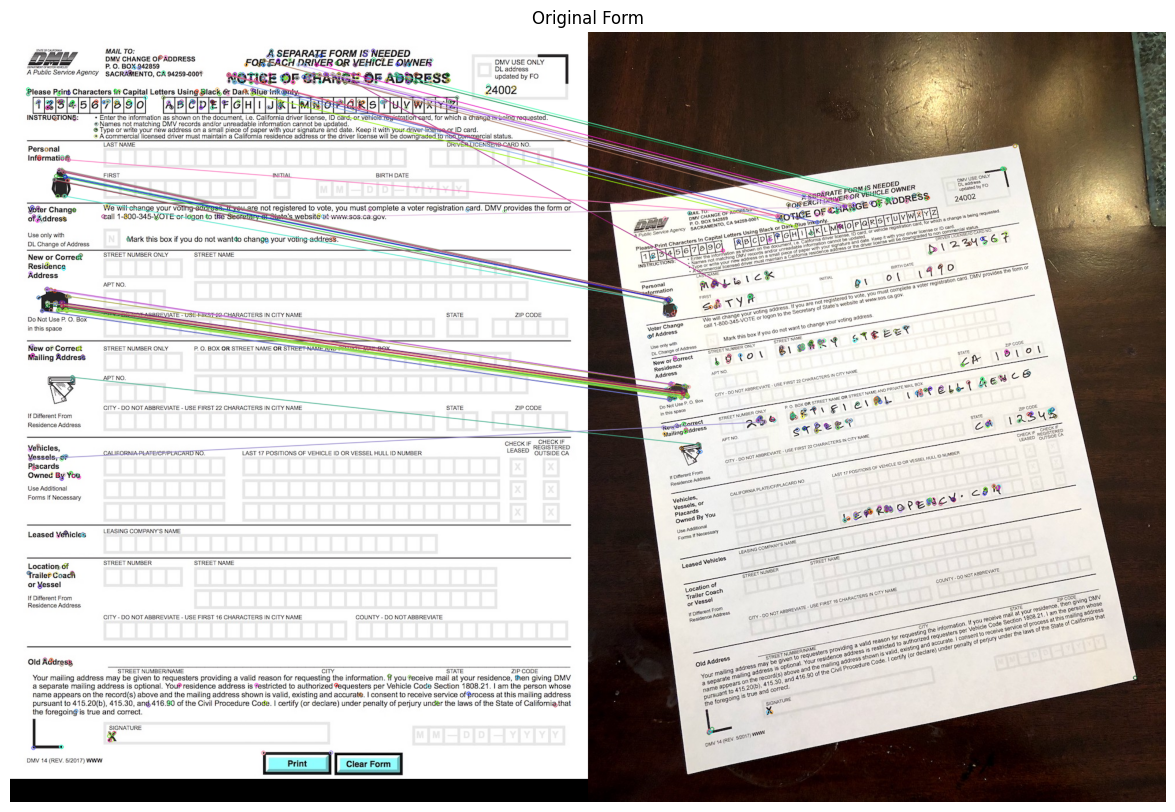

In [10]:
# Match features.
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)

# Converting to list for sorting as tuples are immutable objects.
matches = list(matcher.match(descriptors1, descriptors2, None))

# Sort matches by score
matches.sort(key=lambda x: x.distance, reverse=False)

# Remove not so good matches
numGoodMatches = int(len(matches) * 0.1)
matches = matches[:numGoodMatches]

im_matches = cv2.drawMatches(image1_rgb, keypoints1, image2_rgb, keypoints2, matches, None)
plt.figure(figsize=[40, 10])
plt.imshow(im_matches);plt.axis("off");plt.title("Original Form")

## Find Homography

Homography is a plane that can be calculated with the referece of two planes. Here it is scanned image and template image. To learn more about [homography](https://docs.opencv.org/4.x/d9/dab/tutorial_homography.html) visit the docs.

In [11]:
# Extract location of good matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

# Find homography
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

## Using homography to warp the image

Text(0.5, 1.0, 'Scanned Form')

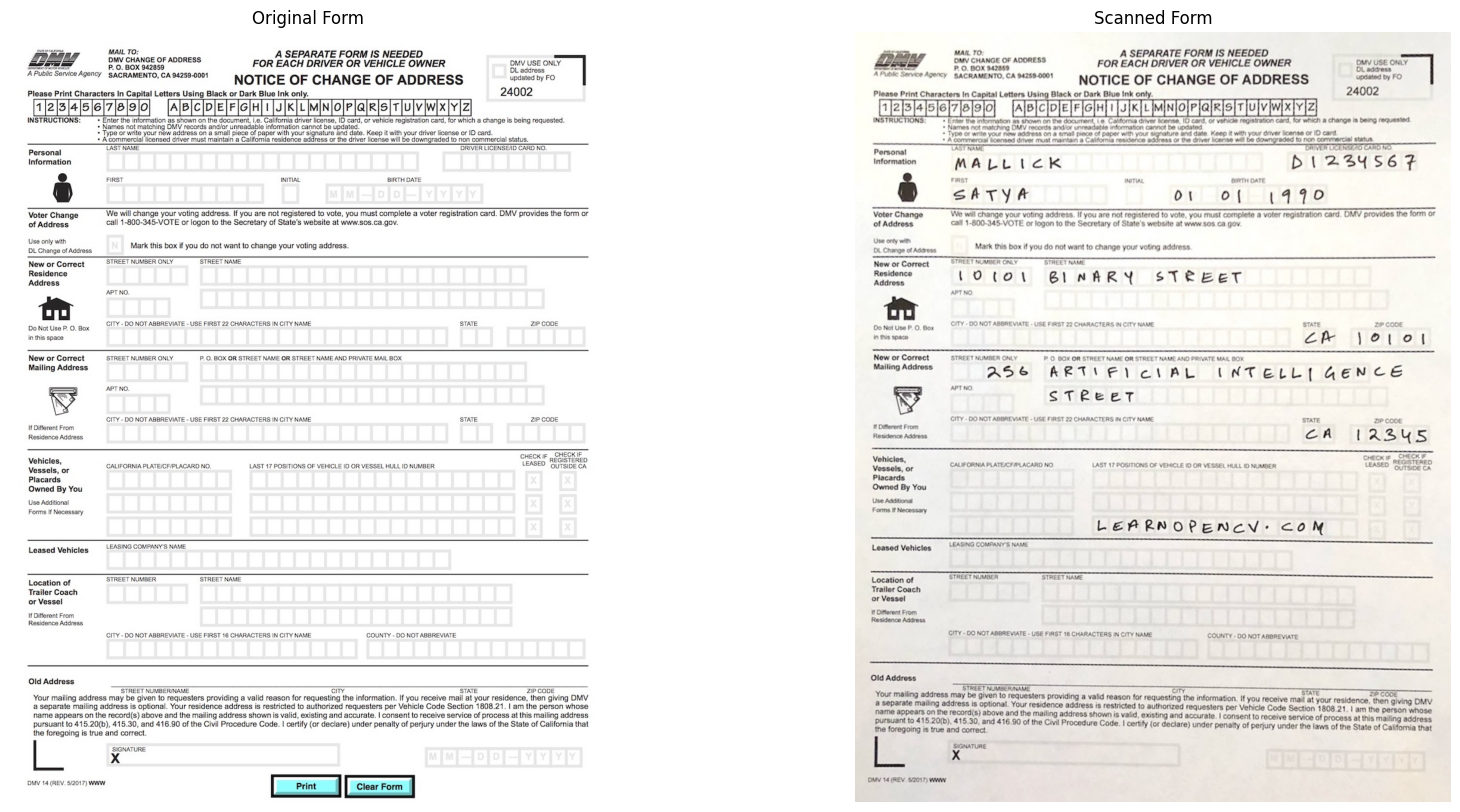

In [12]:
# Use homography to warp image
height, width, channels = image1_rgb.shape
image2_reg = cv2.warpPerspective(image2_rgb, h, (width, height))

# Display results
plt.figure(figsize=[20, 10])
plt.subplot(121);plt.imshow(image1_rgb);    plt.axis("off");plt.title("Original Form")
plt.subplot(122);plt.imshow(image2_reg);plt.axis("off");plt.title("Scanned Form")